# Reinforcement Learning in Finite MDPs

In [1]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

## MDPs

In [1]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
import json
import math
from cliffwalk import CliffWalk
from test_env import ToyEnv1

Setting up the environment

In [2]:
env = CliffWalk(proba_succ=0.98)

####################################################################################
# You probably want to test smaller enviroments before
# env = ToyEnv1(gamma=0.95)
####################################################################################

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")
print(env.R.shape)

Set of states: range(0, 48)
Set of actions: [0, 1, 2, 3]
Number of states:  48
Number of actions:  4
P has shape:  (48, 4, 48)
discount factor:  0.99

initial state:  36
reward at (s=1, a=3,s'=2):  0.6

random policy =  [3 1 2 2 1 2 1 3 2 1 0 2 2 3 2 1 2 3 3 0 0 2 1 1 1 0 1 2 3 1 2 0 2 0 2 1 1
 1 1 0 0 3 1 1 0 3 2 2]
(s, a, s', r):
36 1 36 0.6
36 1 36 0.6
36 1 36 0.6
36 1 36 0.6

(48, 4, 48)


## Question 1: Value iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$
2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition (reuse function implemented in 1)
3. Evaluate the convergence of your estimate, i.e., plot the value $\|Q_n - Q^\star\|_{\infty} = \max_{s,a} |Q_n(s,a) - Q^\star(s,a)|$

In [3]:
# --------------
# Point 1
# --------------
def bellman_operator(Q0, Ns, Na, R, P, gamma):
    V = np.max(Q0, axis=1)
    Q1 = R + gamma * P.dot(V)
    greedy_policy = np.argmax(Q1, axis=1)
    return Q1, greedy_policy

In [4]:
# --------------
# Point 2
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
    # TODO (feel free to change the return argument)
    gamma = env.gamma
    Q_history = [Q0]
    Ns, Na, R, P = env.Ns, env.Na, env.R.mean(2), env.P
    while True:
        Q, greedy_policy = bellman_operator(Q0, Ns, Na, R, P, gamma)
        Q_history.append(Q)
        
        # Stopping criteria
        if np.max(np.abs(Q - Q0)) < epsilon:
            break
        
        Q0 = Q
        
    return Q, greedy_policy, Q_history

Text(0.5, 1.0, 'Q-learning: Convergence of Q')

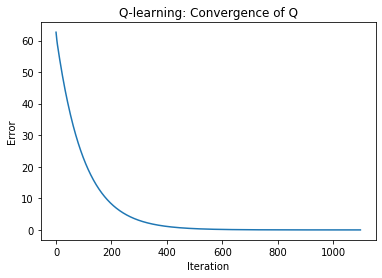

In [5]:
# --------------
# Point 3
# --------------
with open("./mvarl_hands_on/data/Q_opts.json", "r") as fp:
    Qopts = json.load(fp)
Qstar = Qopts["{}_{}".format(type(env).__name__,env.gamma)]

# Random initialization
Q0 = np.random.rand(env.Ns, env.Na)
Q, greedy_policy, Q_history = value_iteration(Q0, env)

# TODO
norm_values = list(map(
    lambda q: np.max(np.abs(q - Qstar)), Q_history
))

plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

In [6]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()
    if done:
        break

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+---------------

## Question 2: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the sum of rewards as a function of iteration


$\epsilon$-greedy policy:
$$
\pi(s) = \begin{cases}
\max_a Q(s,a) & \text{w.p.} \epsilon\\
\text{random action} & \text{w.p.} 1- \epsilon
\end{cases}
$$

In [118]:
class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self, env, lr=0.5, epsilon=0.1, Q_star=None):
        self.env = env
        self.Ns = env.Ns
        self.Na = env.Na
        self.gamma = env.gamma
        self.lr = lr  # learning rate
        self.epsilon = epsilon
        self.Q_star = Q_star  # If we want to compute error
        self.norm_values = []
        
        # Q-table initialization
        self.q_table = np.zeros((self.Ns, self.Na))
    
    def sample_action(self, state):
        if np.random.rand() < self.epsilon:
            # Exploration with epsilon probability
            action = self.env.actions[np.random.randint(self.Na)]
        else:
            # If not, exploit the learnt q values
            action = np.argmax(self.q_table[state])
        return action

    def update(self, state, action, next_state, reward):
        delta_t = reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state, action]
        self.q_table[state, action] += self.lr * delta_t

    def is_done(self, state):
        return 47 > state > 36
    
    def train(self, episodes):
        
        for episode in range(episodes):
            # Initialize a random state
            state = self.env.reset()
            done = False
            
            while True:
                # Sample an action according to the eps-greedy policy
                action = self.sample_action(state)
                next_state, reward, done_last, info = self.env.step(action)
                
                # Update the current state and the Q table
                self.update(state, action, next_state, reward)
                state = next_state
                
                # If the new state is terminal, reset the environment
                if done or self.is_done(next_state):
                    break
                    
                done = done_last
            
            if self.Q_star is not None:
                self.norm_values.append(np.abs(self.q_table - self.Q_star).mean())
    
    def greedy_policy(self):
        return np.argmax(self.q_table, axis=1)
    
    def plot_qtable(self):
        plt.imshow(self.q_table)
    
    def plot_errors(self):
        plt.plot(self.norm_values)
        plt.xlabel('Episode')
        plt.ylabel('Error')
        plt.title("Q-learning: Convergence of Q")

In [119]:
env.reset()

episodes = 2000 # Number of episodes

# Compute Q_opt with value iteration from previous code
Q0 = np.zeros((env.Ns, env.Na))
Q_opt, pi_opt, _ = value_iteration(Q0, env, epsilon=1e-8)

ql = QLearning(env, Q_star=Q_opt)

history = ql.train(episodes)

greedy_policy = ql.greedy_policy()

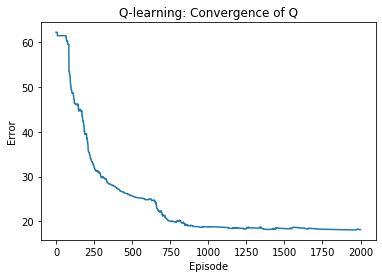

In [120]:
ql.plot_errors()

In [121]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()
    if done:
        break

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| :_: : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : :_: : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+---------------------